# Stock Market Analysis: Large-Cap US Companies

## Objective
Analyze historical price and volume data for 5 large-cap US stocks over the past 10 years to identify performance patterns and volatility trends.

## Dataset
- **Source**: Kaggle US Stocks & ETFs Price-Volume Data
- **Companies**: Apple (AAPL), Microsoft (MSFT), Amazon (AMZN), Tesla (TSLA), Google (GOOGL)
- **Time Period**: 2015-2025 (10 years)
- **Data Structure**: MultiIndexed DataFrame with Ticker and Date levels

## Methodology
1. Data Loading and MultiIndex Creation
2. Data Cleaning and Validation
3. Feature Engineering (Returns, Moving Averages, Volatility)
4. Exploratory Analysis and Insights


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

CONFIG = {
    'data_path': './Stocks/',
    'tickers': ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL'],
    'analysis_years': 10,
    'moving_averages': [7, 30],
    'volatility_window': 30
}

print("Configuration loaded successfully")
print(f"Analyzing {len(CONFIG['tickers'])} stocks: {', '.join(CONFIG['tickers'])}")


Configuration loaded successfully
Analyzing 5 stocks: AAPL, MSFT, AMZN, TSLA, GOOGL


## Step 1: Data Loading and MultiIndex Creation

Loading stock data from individual CSV files and creating a MultiIndexed DataFrame for efficient time series analysis across multiple securities.


In [2]:
def load_stock_data(config: dict) -> pd.DataFrame:
    """
    Load stock data for specified tickers into MultiIndexed DataFrame.
    
    Args:
        config: Configuration dictionary with tickers and data path
        
    Returns:
        MultiIndexed DataFrame with (Ticker, Date) structure
    """
    data_frames = []
    successful_loads = []
    
    for ticker in config['tickers']:
        file_path = f"{config['data_path']}{ticker.lower()}.us.txt"
        try:
            df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
            data_frames.append(df)
            successful_loads.append(ticker)
            print(f"✓ Loaded {ticker}: {len(df)} records")
        except FileNotFoundError:
            print(f"✗ File not found: {ticker}")
    
    if not data_frames:
        raise ValueError("No data files could be loaded")
    
    combined_df = pd.concat(data_frames, keys=successful_loads, names=['Ticker', 'Date'])
    print(f"\nCombined dataset shape: {combined_df.shape}")
    return combined_df

combined_df = load_stock_data(CONFIG)


✓ Loaded AAPL: 8364 records
✓ Loaded MSFT: 7983 records
✓ Loaded AMZN: 5153 records
✓ Loaded TSLA: 1858 records
✓ Loaded GOOGL: 3333 records

Combined dataset shape: (26691, 6)


## Step 2: Data Cleaning and Validation

Handling missing values, ensuring data quality, and filtering to the specified time period.


In [3]:
def clean_stock_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean stock data by handling missing values and ensuring data quality.
    
    Args:
        df: MultiIndexed DataFrame with stock data
        
    Returns:
        Cleaned DataFrame
    """
    print("=== Data Cleaning Summary ===")
    
    missing_summary = df.isnull().groupby(level='Ticker').sum()
    print("Missing values per ticker:")
    print(missing_summary)
    
    price_cols = ['Open', 'High', 'Low', 'Close']
    df[price_cols] = df.groupby(level='Ticker')[price_cols].ffill()
    df[price_cols] = df.groupby(level='Ticker')[price_cols].transform(
        lambda x: x.interpolate(method='linear')
    )
    
    df['Volume'] = df.groupby(level='Ticker')['Volume'].transform(
        lambda x: x.fillna(x.median())
    )
    
    return df

def filter_date_range(df: pd.DataFrame, years: int) -> pd.DataFrame:
    """
    Filter DataFrame to specified number of years from current date.
    
    Args:
        df: MultiIndexed DataFrame
        years: Number of years to include
        
    Returns:
        Filtered DataFrame
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)
    
    date_mask = df.index.get_level_values('Date') >= start_date
    filtered_df = df[date_mask]
    
    print(f"Filtered to {years} years: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"Records per ticker after filtering:")
    print(filtered_df.groupby(level='Ticker').size())
    
    return filtered_df

def validate_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Validate data quality and check for inconsistencies.
    
    Args:
        df: DataFrame to validate
        
    Returns:
        Validated DataFrame
    """
    print("\n=== Data Validation ===")
    
    total_nulls = df.isnull().sum().sum()
    print(f"Remaining missing values: {total_nulls}")
    
    invalid_prices = (
        (df['High'] < df['Low']) |
        (df['Close'] > df['High']) |
        (df['Close'] < df['Low'])
    ).sum()
    print(f"Invalid price relationships: {invalid_prices}")
    
    if invalid_prices > 0:
        print("Warning: Found invalid price relationships - manual review recommended")
    
    return df

cleaned_df = clean_stock_data(combined_df)
filtered_df = filter_date_range(cleaned_df, CONFIG['analysis_years'])
validated_df = validate_data(filtered_df)


=== Data Cleaning Summary ===
Missing values per ticker:
        Open  High  Low  Close  Volume  OpenInt
Ticker                                         
AAPL       0     0    0      0       0        0
AMZN       0     0    0      0       0        0
GOOGL      0     0    0      0       0        0
MSFT       0     0    0      0       0        0
TSLA       0     0    0      0       0        0
Filtered to 10 years: 2015-06-06 to 2025-06-03
Records per ticker after filtering:
Ticker
AAPL     615
AMZN     615
GOOGL    615
MSFT     615
TSLA     615
dtype: int64

=== Data Validation ===
Remaining missing values: 0
Invalid price relationships: 0


## Step 3: Feature Engineering / Data Transformation

Adding technical indicators including daily returns, moving averages, and volatility measures.


In [4]:
def create_technical_indicators(df: pd.DataFrame, config: dict) -> pd.DataFrame:
    """
    Calculate technical indicators using configuration parameters.
    
    Args:
        df: MultiIndexed DataFrame with stock data
        config: Configuration dictionary
        
    Returns:
        DataFrame with added technical indicators
    """
    df = df.copy()
    print("=== Adding Technical Indicators ===")
    
    df['Daily Return'] = df.groupby(level='Ticker')['Close'].pct_change() * 100
    print("✓ Daily Return calculated")
    
    for window in config['moving_averages']:
        col_name = f'{window}-day MA'
        df[col_name] = df.groupby(level='Ticker')['Close'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        print(f"✓ {col_name} calculated")
    
    volatility_col = f'Rolling Volatility ({config["volatility_window"]}d)'
    df[volatility_col] = df.groupby(level='Ticker')['Daily Return'].transform(
        lambda x: x.rolling(window=config['volatility_window'], min_periods=1).std()
    )
    print(f"✓ {volatility_col} calculated")
    
    print(f"\nFinal dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    return df

enhanced_df = create_technical_indicators(validated_df, CONFIG)


=== Adding Technical Indicators ===
✓ Daily Return calculated
✓ 7-day MA calculated
✓ 30-day MA calculated
✓ Rolling Volatility (30d) calculated

Final dataset shape: (3075, 10)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'Daily Return', '7-day MA', '30-day MA', 'Rolling Volatility (30d)']


## Step 4: Exploratory Analysis

Analyzing performance metrics to answer key questions about returns and volatility patterns.


In [5]:
def exploratory_analysis(df: pd.DataFrame) -> dict:
    """
    Perform comprehensive analysis of stock performance and volatility.
    
    Args:
        df: Enhanced DataFrame with technical indicators
        
    Returns:
        Dictionary containing analysis results
    """
    print("=== Performance Analysis ===")
    
    average_returns = df.groupby(level='Ticker')['Daily Return'].mean()
    highest_return_stock = average_returns.idxmax()
    highest_return_value = average_returns.max()
    
    print(f"Stock with highest average return: {highest_return_stock}")
    print(f"Average daily return: {highest_return_value:.4f}%")
    print(f"Annualized return (approx): {highest_return_value * 252:.2f}%")
    
    print("\nAll stocks average daily returns:")
    for ticker, return_val in average_returns.sort_values(ascending=False).items():
        print(f"{ticker}: {return_val:.4f}%")
    
    print("\n=== Volatility Analysis ===")
    
    monthly_volatility = df.groupby(level='Ticker')['Daily Return'].resample('ME', level='Date').std()
    most_volatile_idx = monthly_volatility.idxmax()
    most_volatile_value = monthly_volatility.max()
    
    print(f"Most volatile month: {most_volatile_idx[1].strftime('%B %Y')}")
    print(f"Stock: {most_volatile_idx[0]}")
    print(f"Monthly volatility: {most_volatile_value:.4f}%")
    
    volatility_summary = df.groupby(level='Ticker')['Daily Return'].std()
    print(f"\nOverall volatility ranking:")
    for ticker, vol in volatility_summary.sort_values(ascending=False).items():
        print(f"{ticker}: {vol:.4f}%")
    
    risk_return_metrics = pd.DataFrame({
        'Average Return': average_returns,
        'Volatility': volatility_summary,
        'Sharpe Ratio': average_returns / volatility_summary
    }).round(4)
    
    print(f"\n=== Risk-Return Summary ===")
    print(risk_return_metrics.sort_values('Sharpe Ratio', ascending=False))
    
    return {
        'highest_return_stock': highest_return_stock,
        'highest_return_value': highest_return_value,
        'most_volatile_stock': most_volatile_idx[0],
        'most_volatile_month': most_volatile_idx[1],
        'most_volatile_value': most_volatile_value,
        'risk_return_metrics': risk_return_metrics
    }

analysis_results = exploratory_analysis(enhanced_df)

=== Performance Analysis ===
Stock with highest average return: AMZN
Average daily return: 0.1741%
Annualized return (approx): 43.89%

All stocks average daily returns:
AMZN: 0.1741%
MSFT: 0.1172%
GOOGL: 0.1164%
AAPL: 0.0689%
TSLA: 0.0571%

=== Volatility Analysis ===
Most volatile month: February 2016
Stock: TSLA
Monthly volatility: 4.6379%

Overall volatility ranking:
TSLA: 2.4407%
AMZN: 1.7354%
AAPL: 1.4430%
GOOGL: 1.4330%
MSFT: 1.3435%

=== Risk-Return Summary ===
        Average Return  Volatility  Sharpe Ratio
Ticker                                          
AMZN            0.1741      1.7354        0.1003
MSFT            0.1172      1.3435        0.0872
GOOGL           0.1164      1.4330        0.0813
AAPL            0.0689      1.4430        0.0478
TSLA            0.0571      2.4407        0.0234


In [6]:
analysis_results

{'highest_return_stock': 'AMZN',
 'highest_return_value': np.float64(0.17414900537851913),
 'most_volatile_stock': 'TSLA',
 'most_volatile_month': Timestamp('2016-02-29 00:00:00'),
 'most_volatile_value': np.float64(4.637916401955757),
 'risk_return_metrics':         Average Return  Volatility  Sharpe Ratio
 Ticker                                          
 AAPL            0.0689      1.4430        0.0478
 AMZN            0.1741      1.7354        0.1003
 GOOGL           0.1164      1.4330        0.0813
 MSFT            0.1172      1.3435        0.0872
 TSLA            0.0571      2.4407        0.0234}

## Step 5: Data Visualization

Creating visualizations to better understand the performance patterns and trends.


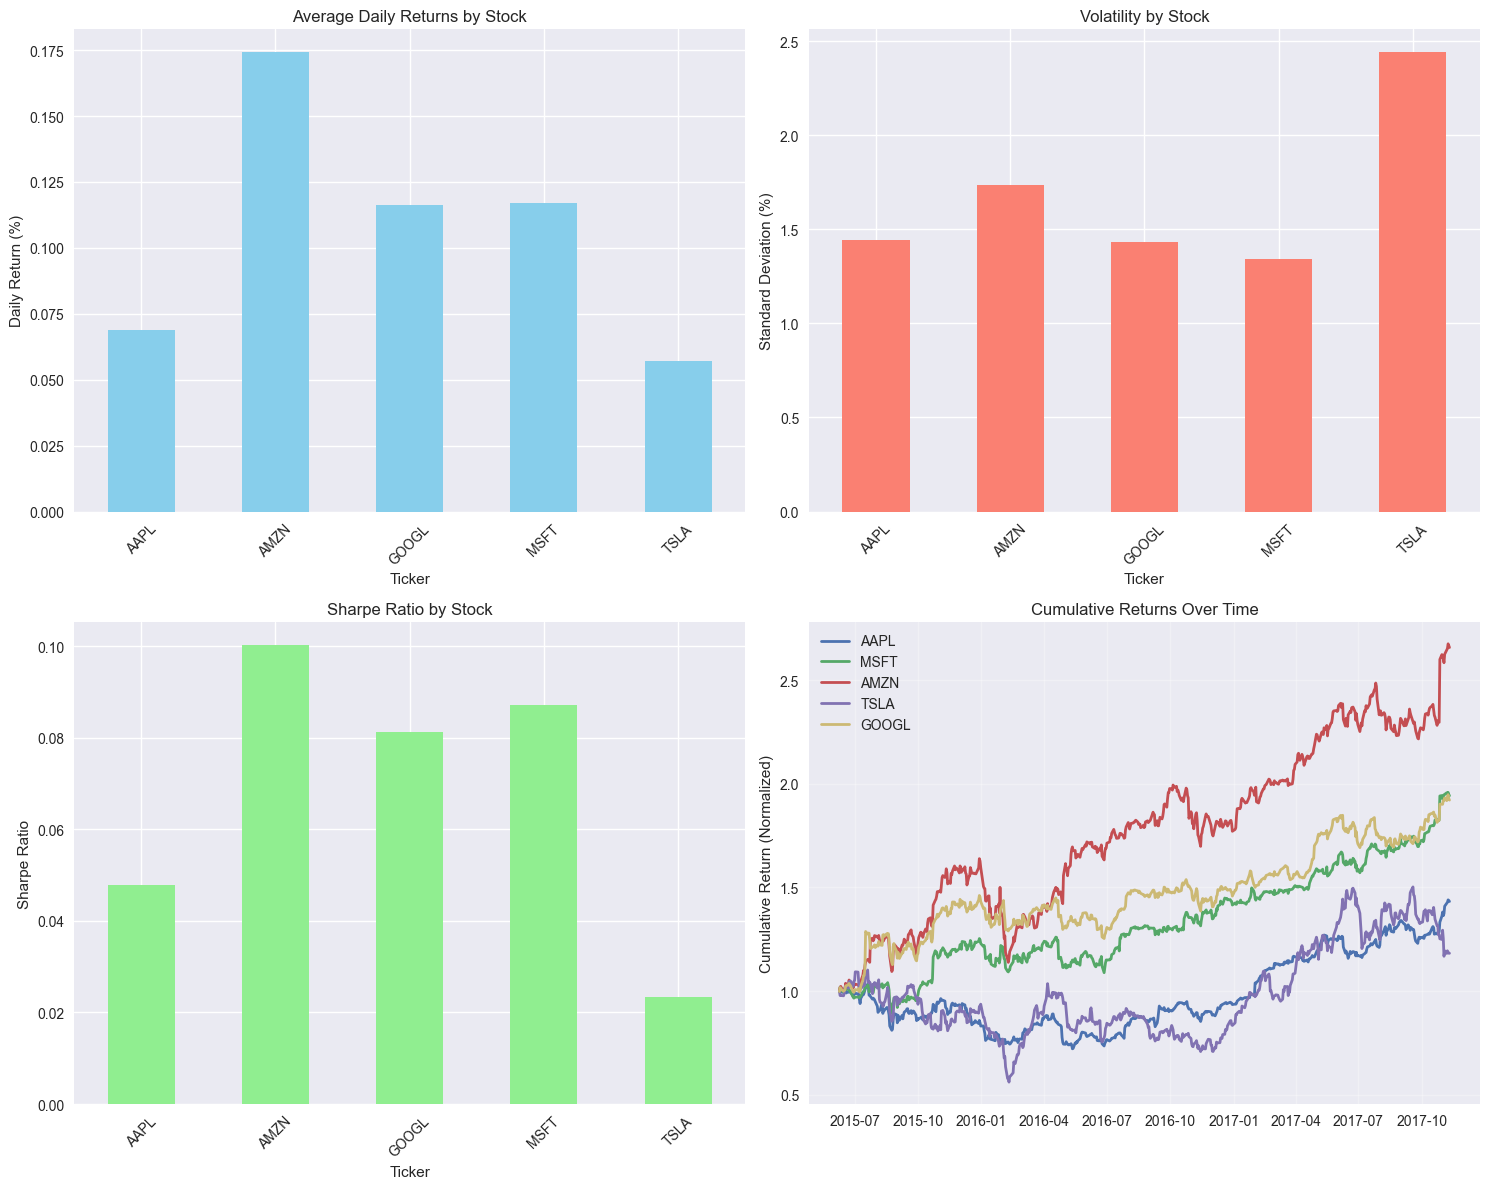

In [7]:
def create_visualizations(df: pd.DataFrame, results: dict):
    """
    Create comprehensive visualizations for the analysis.
    
    Args:
        df: Enhanced DataFrame with all indicators
        results: Analysis results dictionary
    """
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    returns_data = df.groupby(level='Ticker')['Daily Return'].mean()
    returns_data.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Average Daily Returns by Stock')
    axes[0,0].set_ylabel('Daily Return (%)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    volatility_data = df.groupby(level='Ticker')['Daily Return'].std()
    volatility_data.plot(kind='bar', ax=axes[0,1], color='salmon')
    axes[0,1].set_title('Volatility by Stock')
    axes[0,1].set_ylabel('Standard Deviation (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    sharpe_ratios = results['risk_return_metrics']['Sharpe Ratio']
    sharpe_ratios.plot(kind='bar', ax=axes[1,0], color='lightgreen')
    axes[1,0].set_title('Sharpe Ratio by Stock')
    axes[1,0].set_ylabel('Sharpe Ratio')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    for ticker in CONFIG['tickers']:
        ticker_data = df.xs(ticker, level='Ticker')
        cumulative_returns = (1 + ticker_data['Daily Return']/100).cumprod()
        axes[1,1].plot(cumulative_returns.index, cumulative_returns, label=ticker, linewidth=2)
    
    axes[1,1].set_title('Cumulative Returns Over Time')
    axes[1,1].set_ylabel('Cumulative Return (Normalized)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

create_visualizations(enhanced_df, analysis_results)
